# Experiment #1

## Goals
* Build pipeline that translates audio WAV data captured into trianing data set.

## Data Representation
1. Take the set of all WAV files, load them as raw data vectors, and segment them using their beat onset data.
2. Scale each of these to a equivalent time-scale.
3. Perform a FFT of each, now take this data and save it out as the final output. If it's a 2D vector then collapse it down.

## Playing around with FFTs

Populating the interactive namespace from numpy and matplotlib


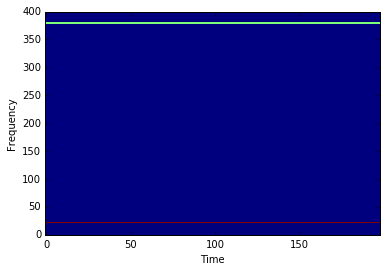

[  0.00000000e+00   2.09994924e-05   1.58054349e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


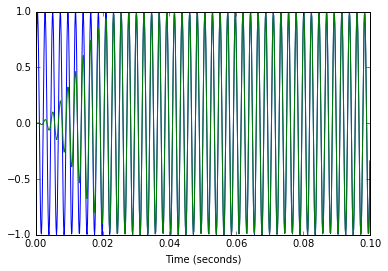

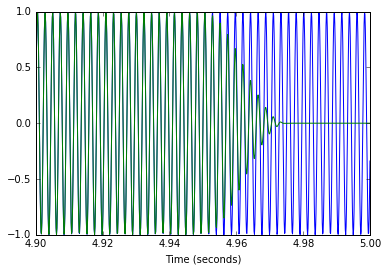

In [2]:
# Cheap code from StackOverflow ahead...

%pylab --no-import-all inline

import scipy, numpy as np

def stft(x, fs, framesz, hop):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hanning(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

def istft(X, fs, T, hop):
    x = scipy.zeros(T*fs)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
    return x

f0 = 440         # Compute the STFT of a 440 Hz sinusoid
fs = 8000        # sampled at 8 kHz
T = 5            # lasting 5 seconds
framesz = 0.050  # with a frame size of 50 milliseconds
hop = 0.025      # and hop size of 25 milliseconds.

# Create test signal and STFT.
t = scipy.linspace(0, T, T*fs, endpoint=False)
x = scipy.sin(2*scipy.pi*f0*t)
X = stft(x, fs, framesz, hop)

# Plot the magnitude spectrogram.
pylab.figure()
pylab.imshow(scipy.absolute(X.T), origin='lower', aspect='auto',
             interpolation='nearest')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.show()

# Compute the ISTFT.
xhat = istft(X, fs, T, hop)

print xhat

# Plot the input and output signals over 0.1 seconds.
T1 = int(0.1*fs)

pylab.figure()
pylab.plot(t[:T1], x[:T1], t[:T1], xhat[:T1])
pylab.xlabel('Time (seconds)')

pylab.figure()
pylab.plot(t[-T1:], x[-T1:], t[-T1:], xhat[-T1:])
pylab.xlabel('Time (seconds)')

In [4]:
print 'size of the input sine wave array: %s' % str(x.shape)
print 'size of the SFFT array: %s' % str(X.shape)
print 'total data points in SFFT array: %d' % (X.shape[0] * X.shape[1])
print 'size of output array: %s' % str(xhat.shape)

print X

# It's clear there's more data in the SFFT transform than there was in the original.. 
# Note that we also have all that imaginary data in SFFT, we need to 

size of the input sine wave array: (40000L,)
size of the SFFT array: (198L, 400L)
total data points in SFFT array: 79200
size of output array: (40000L,)
[[-0.00017798 +0.00000000e+00j -0.00017835 -9.51646306e-05j
  -0.00017949 -1.92731150e-04j ..., -0.00018142 +2.95255261e-04j
  -0.00017949 +1.92731150e-04j -0.00017835 +9.51646306e-05j]
 [-0.00017798 +0.00000000e+00j -0.00017835 -9.51646306e-05j
  -0.00017949 -1.92731150e-04j ..., -0.00018142 +2.95255262e-04j
  -0.00017949 +1.92731150e-04j -0.00017835 +9.51646306e-05j]
 [-0.00017798 +0.00000000e+00j -0.00017835 -9.51646306e-05j
  -0.00017949 -1.92731150e-04j ..., -0.00018142 +2.95255261e-04j
  -0.00017949 +1.92731150e-04j -0.00017835 +9.51646306e-05j]
 ..., 
 [-0.00017798 +0.00000000e+00j -0.00017835 -9.51646283e-05j
  -0.00017949 -1.92731152e-04j ..., -0.00018142 +2.95255257e-04j
  -0.00017949 +1.92731152e-04j -0.00017835 +9.51646283e-05j]
 [-0.00017798 +0.00000000e+00j -0.00017835 -9.51646305e-05j
  -0.00017949 -1.92731149e-04j ..., 

## Loading Training Data + Splitting into Beats + Forcing to Mono

(20808L,)
(22581L,)
(23984L,)
(20478L,)
(22211L,)
(22582L,)
(22935L,)
(20462L,)
(22220L,)
(21874L,)
(23991L,)
(20109L,)
(21874L,)
(22593L,)
(23629L,)
(21872L,)
(23636L,)
(21170L,)
(22581L,)
(21869L,)
(22583L,)
(21878L,)
(23276L,)
(20815L,)
(22582L,)
(21524L,)
(23286L,)
(21163L,)
(22930L,)
(22583L,)
(23285L,)
(22049L,)
(23812L,)
(18699L,)
(21873L,)
(21888L,)
(23461L,)
(21333L,)
(21517L,)
(22586L,)
(23283L,)
(22235L,)
(22765L,)
(23263L,)
(22931L,)
(22240L,)
(20810L,)
(20811L,)
(23993L,)
(21868L,)
(22931L,)
(22934L,)
(21518L,)
(22230L,)
(21871L,)


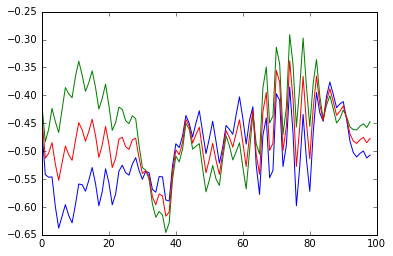

In [5]:
# Okay, okay. Let's build a cheap API over the data file representation.
# Right now our input folder is E:\projects\trainingData\beatSamples.v1.
# Transform 1
# - Take all the input data that also has beat data
# - Splice it up into beats and discard the rest
# - Merge the stereo channels together into a single mono stream
# - Use phase vocoder algorithm for time stretching to normalize everything to 500ms per beat
# - (allows us to learn a representation grounded close to the music staff representation itself quicker)
# - Save the output files in a raw data file format <orig>.N.dat
import scipy, numpy as np, scipy.io.wavfile

# Load the beat data and remove any negative values that
# started before recording started.
beats = np.loadtxt('E:\\projects\\trainingData\\beatSamples.v1\\20160506160348935.beats.txt')
beats = np.delete(beats, np.where(beats < 0))

audioData = scipy.io.wavfile.read('E:\\projects\\trainingData\\beatSamples.v1\\20160506160348935.wav')
hz = audioData[0]
stereoStream = audioData[1]
# Takes the given audio stream and downconverts it into a single-channel
# mono source normalized between [-1..1] (approximately)
monoStream = np.sum(stereoStream, 1)
monoStream = np.divide(monoStream, 2)

# Ensure our mono stream actually looks reasonable...
plt.plot(stereoStream[1:100,:])
plt.plot(monoStream[1:100])

# frequency steps per beat time step
# (unit of audio time/sec) / (sec/unit of beat time)
fqUnitsPerBeatUnit = hz / 1000.0 / 10000.0

beats = np.floor(np.multiply(beats, fqUnitsPerBeatUnit))

# And now split everything into individual beats, being
# careful to trim out the first and last sample, which
# aren't between two known beats.
audioBeats = np.split(monoStream, beats)[1:-1]

# And lets see how reasonable all our beats are in terms of their
# size in samples. Assuming ~120bpm they should each be around 22050
# samples wide.
for b in audioBeats:
    print b.shape


## Phase Vocoding Experiments

In [44]:
# Taken from Spectral, simple code to get our audio source
# operating

import io
import pyglet.media.avbin
class NpAudioSource(pyglet.media.Source):
    def __init__(self, source, audio_format):
        self.audio_format = audio_format
        # Source is usually a numpy array...
        self.buff = source
        self.buffPos = 0
        self.buffLen = source.shape[0] * self.audio_format.bytes_per_sample * self.audio_format.channels
        self._duration = float(self.buffLen) / self.audio_format.bytes_per_second
        print 'Creating AudioSource, Duration %f' % self._duration
    
    def get_audio_data(self, bytes):
        timestamp = float(self.buffPos) / self.audio_format.bytes_per_second
        
        # Align to sample size
        if self.audio_format.bytes_per_sample == 2:
            bytes &= 0xfffffffe
        elif self.audio_format.bytes_per_sample == 4:
            bytes &= 0xfffffffc

        remainingBytes = self.buffLen - self.buffPos
        toRead = min(remainingBytes, bytes)
        if (toRead == 0): return None
        
        duration = toRead / self.audio_format.bytes_per_second
        
        # We really always expect our true source to be a numpy array of
        # 32-bit floats, that we then scale to integer percision, and finally
        # shoot out as N channels of 32-bit signed int audio data.
        currPos = self.buffPos / (self.audio_format.bytes_per_sample * self.audio_format.channels)
        endPos = (self.buffPos + toRead) / (self.audio_format.bytes_per_sample * self.audio_format.channels) 
        
        data = np.array(self.buff[currPos:endPos])
        data = np.multiply(data, np.iinfo(np.int32).max).astype(dtype=np.int32)
        data = data.flatten().tostring()
        
        self.buffPos += toRead

        print 'getting %d bytes, timestamp %f, buff_pos %d!' % (len(data), timestamp, self.buffPos)
        return pyglet.media.AudioData(data, len(data), timestamp, duration, [])
    

def playNp(np):
    NpAudioSource(np, pyglet.media.AudioFormat(1, 32, 44100)).play()


In [33]:
import time

# Play a few samples to make sure everything sounds good...
for i in range(20):
    playNp(audioBeats[i])
    time.sleep(1)


Creating AudioSource, Duration 0.471837
getting 44800 bytes, timestamp 0.000000, buff_pos 44800!
getting 12352 bytes, timestamp 0.253968, buff_pos 57152!
getting 17640 bytes, timestamp 0.323991, buff_pos 74792!
getting 8440 bytes, timestamp 0.423991, buff_pos 83232!
Creating AudioSource, Duration 0.512041
getting 44800 bytes, timestamp 0.000000, buff_pos 44800!
getting 12352 bytes, timestamp 0.253968, buff_pos 57152!
getting 19404 bytes, timestamp 0.323991, buff_pos 76556!
getting 13768 bytes, timestamp 0.433991, buff_pos 90324!
Creating AudioSource, Duration 0.543855
getting 44800 bytes, timestamp 0.000000, buff_pos 44800!
getting 14116 bytes, timestamp 0.253968, buff_pos 58916!
getting 17640 bytes, timestamp 0.333991, buff_pos 76556!
getting 17640 bytes, timestamp 0.433991, buff_pos 94196!
getting 1740 bytes, timestamp 0.533991, buff_pos 95936!
Creating AudioSource, Duration 0.464354
getting 44800 bytes, timestamp 0.000000, buff_pos 44800!
getting 12352 bytes, timestamp 0.253968, buf

3.14159265359
L 99999, N 1024, H 256
tick: p 0, pp 0
tick: p 256, pp 256
tick: p 512, pp 512
tick: p 768, pp 768
tick: p 1024, pp 1024
tick: p 1280, pp 1280
tick: p 1536, pp 1536
tick: p 1792, pp 1792
tick: p 2048, pp 2048
tick: p 2304, pp 2304
tick: p 2560, pp 2560
tick: p 2816, pp 2816
tick: p 3072, pp 3072
tick: p 3328, pp 3328
tick: p 3584, pp 3584
tick: p 3840, pp 3840
tick: p 4096, pp 4096
tick: p 4352, pp 4352
tick: p 4608, pp 4608
tick: p 4864, pp 4864
tick: p 5120, pp 5120
tick: p 5376, pp 5376
tick: p 5632, pp 5632
tick: p 5888, pp 5888
tick: p 6144, pp 6144
tick: p 6400, pp 6400
tick: p 6656, pp 6656
tick: p 6912, pp 6912
tick: p 7168, pp 7168
tick: p 7424, pp 7424
tick: p 7680, pp 7680
tick: p 7936, pp 7936
tick: p 8192, pp 8192
tick: p 8448, pp 8448
tick: p 8704, pp 8704
tick: p 8960, pp 8960
tick: p 9216, pp 9216
tick: p 9472, pp 9472
tick: p 9728, pp 9728
tick: p 9984, pp 9984
tick: p 10240, pp 10240
tick: p 10496, pp 10496
tick: p 10752, pp 10752
tick: p 11008, pp 11008

getting 15880 bytes, timestamp 0.253968, buff_pos 60680!
getting 21168 bytes, timestamp 0.343991, buff_pos 81848!


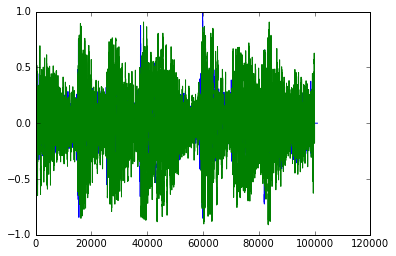

getting 10584 bytes, timestamp 0.463991, buff_pos 92432!
getting 17640 bytes, timestamp 0.523991, buff_pos 110072!
getting 17640 bytes, timestamp 0.623991, buff_pos 127712!
getting 17640 bytes, timestamp 0.723991, buff_pos 145352!
getting 17640 bytes, timestamp 0.823991, buff_pos 162992!
getting 17640 bytes, timestamp 0.923991, buff_pos 180632!
getting 17640 bytes, timestamp 1.023991, buff_pos 198272!
getting 17640 bytes, timestamp 1.123991, buff_pos 215912!
getting 19404 bytes, timestamp 1.223991, buff_pos 235316!
getting 15876 bytes, timestamp 1.333991, buff_pos 251192!
getting 10584 bytes, timestamp 1.423991, buff_pos 261776!
getting 17640 bytes, timestamp 1.483991, buff_pos 279416!
getting 17640 bytes, timestamp 1.583991, buff_pos 297056!
getting 17640 bytes, timestamp 1.683991, buff_pos 314696!
getting 17640 bytes, timestamp 1.783991, buff_pos 332336!
getting 17640 bytes, timestamp 1.883991, buff_pos 349976!
getting 17640 bytes, timestamp 1.983991, buff_pos 367616!
getting 17640 b

In [84]:
import time

# Now let's take those beat samples and stretch them all to fit within 0.5s of audio
# using a simple phase vocoder. (https://audioprograming.wordpress.com/2012/03/02/a-phase-vocoder-in-python/)

def pvoco(signalin, tscale):
    # Fourier bucket size
    N = 1024

    # Hop size is a sort of pseudo-bucket that allows us to
    # perform the right phase integration
    H = N/4
    
    L = signalin.shape[0]
    
    # signal blocks for processing and output
    
    # We keep track of the current phase for each FFT bucket
    # to continue to scale linearily in the fq domain.
    phi  = np.zeros(N)
    out = np.zeros(N, dtype=complex)
    
    # Signal size... L * tscale + extra buckets
    sigout = np.zeros(L*tscale+N)
    # Hanning window, nothing fancy
    win = np.hanning(N)
    
    # p and pp -> scaling variables.
    # P scans our input array.
    # PP scans out output array. 
    p = 0
    pp = 0
    
    print 'L %d, N %d, H %d' % (L, N, H)
    # Scan p from 0..(L - (bucket size) - (hop size))
    while p < L-(N+H):
        print 'tick: p %d, pp %d' % (p, pp)
        # take the spectra of two consecutive windows
        # Floor these two values so we can use them as array indexes.
        p1 = int(p)
        pp1 = int(pp)
        
        # Build the spectrum of the current window
        # and the next window.
        spec1 = scipy.fft(win*signalin[p1:p1+N])
        spec2 = scipy.fft(win*signalin[p1+H:p1+N+H])
        # Take their phase difference and sum-integrate it into
        # our current angle offset.
        phi += (np.angle(spec2) - np.angle(spec1))
        
        out.real, out.imag = np.cos(phi), np.sin(phi)
        
        # inverse FFT and overlap-add. We take the
        # magnitude of the second spectrum multiplied by
        # the phi? Is that right?
        sigout[pp1:pp1+N] += win * scipy.real(scipy.ifft(abs(spec2)*out))
        
        # Move our input signal scan forward H units.
        p += H
        # Move our output signal scan forward H*TScale units.
        pp += H * tscale

    return sigout / np.max(np.abs(sigout))

def calcTScale(signalin):
    # Because all our samples are at 44.1kHz, and because
    # we want to stretch them to 120bpm beats (500ms)...
    # TScale => input sample length * (TScale) = output sample length
    tscale = (44100.0 / 2) / signalin.shape[0]
    return tscale
    
    
s = audioBeats[0]

print np.pi
#outS = pvoco(s, calcTScale(s))

#playNp(audioBeats[0])
#time.sleep(1)
#playNp(outS)
#playNp(monoStream[1:100000])

ss = monoStream[1:100000]
msOut = pvoco(ss, 1)

playNp(msOut)
time.sleep(3)
playNp(ss)
ss.shape

plt.plot(msOut)
plt.plot(ss)





In [72]:
97280+2048 # Still before...
97280+2048+512 # After...

99840

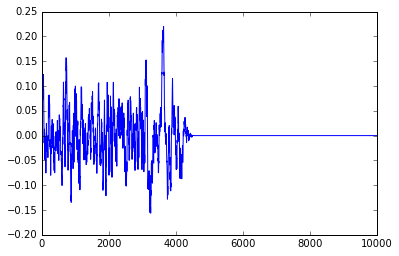

In [66]:
plt.plot(msOut[-10000:])


# Take Aways

* Opening the data and splitting into beats is straight-forward, as is forcing the audio into a mono track.
* Phase vocoding is a reasonable time-stretching strategy, it's simple enough to implement, but it doesn't super high-quality results.
* The devil is in the details, high-quality libraries employ a lot of tricks and heuristics to achieve really reasonable time-stretching.
* As time-stretching is really just a minor one of the many input operations, it seems prudent to simply reuse a high-quality open source library.
* See rubberband- https://bitbucket.org/breakfastquay/rubberband/src

* We'll likely want to build an interface that allows us to overlap the beats and include ~10-50ms of audio from ends of the beat, or at least have the option.
* Integrating with rubberband will likely require us to provide header/tailer audio to prime the algorithm, and then chop out the exact beat after stretching.
* We next need to integrate and define a output file name schema that lets us easily find sequential beats.
* Saving the audio data out to CSV is probably the best format for our usage. It's only ~2x the space as raw binary data, and processes much easier.

